# 🇬🇧 Practical: UK Demography, Sports, and Regression Modeling

## Notebook 2: Iterative Regression Modeling
__Objective__: To build and refine a Multiple Linear Regression model step-by-step, assessing model performance and validity through systematic residual analysis.

We begin with one of the strongest predictors identified in Notebook 1 and iteratively introduce new features up to three independent variables. 

#### The iterative process:
1. __Build initial model__: use the previously chosen predictor (independent variable).
2. __Evaluate numerical metrics__ to assess overall fit.
3. __Analyse the residual distribution__: Critically examine the model's errors (residuals) using histograms, boxplots, and Q-Q plots.
4. __Refine model__: Analyse the joint distributions of the residuals against values of the features looking for patterns in the errors to inform the selection of the next predictor.
5. __Compare__: Compare the new model with the previous one(s) regarding fitness and error distribution.

In [1]:
import pandas as pd
import statsmodels.api as sm
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import pearsonr
from scipy import stats # Needed for qqplot in general

The following code defined the function that loads the data from the specified file.

In [2]:
# --- 1. Load Data ---
def load_data(file_path):
    try:
        df = pd.read_csv(file_path)
        return df
    except FileNotFoundError:
        print(f"Error: The file '{file_path}' was not found. Please ensure it is in the correct directory.")
        exit()

The following code defines the procedure '_run_regression_', which will be used for creating different versions of the model. The code creates a clean version of the dataframe including only the columns used for the model building. After the model is built, the code adds a column to the clean dataframe where it puts the model residuals (errors). The distributions of the residuals need to be analysed in the model diagnostics step.

In [3]:
# --- Regression Functions ---
def run_regression(df, target_var, predictors): 
    cols_to_use = ['id'] + [target_var] + predictors
    df_clean = df[cols_to_use].dropna().copy()
    Y = df_clean[target_var]
    if len(predictors) == 1:
        X = sm.add_constant(df_clean[predictors[0]])
    else:
        X = sm.add_constant(df_clean[predictors])
    model = sm.OLS(Y, X).fit()
    df_clean['Residuals'] = model.resid
    return df_clean, model

The following procedure '_print_model_summary_' outputs the __numeric characteristics of the model__ and the __regression formula__.

In [4]:
def print_model_summary(model, target_var, predictors):
    print("--- Regression Model Summary ---")
    print(model.summary())
    print("\n--- Regression Formula ---")
    intercept = model.params.const
    if len(predictors) == 1:
        predictor_coeff = model.params[predictors[0]]
        print(f"{target_var} = {intercept:.2f} + ({predictor_coeff:.2f} * {predictors[0]})")
    else:
        formula = f"{target_var} = {intercept:.2f} " + " ".join(
            [f"+ ({model.params[p]:.2f} * {p})" for p in predictors])
        print(formula)

The following code defines a procedure that visualizes the distribution of residuals for a single regression model in a __histogram__, __box plot__, and __Q-Q plot__.
    Arguments:
        residuals_series (pd.Series): A Pandas Series containing the model residuals.
        model_name (str): The name of the model (e.g., 'Model 1: Univariate').
    Examples of calling:    
    plot_single_model_diagnostics(df_clean_uni['Residuals'], 'Model 1: Univariate (Age)')
    plot_single_model_diagnostics(df_clean_bi['Residuals'], 'Model 2: Bivariate (Age + Education)')

In [5]:
def plot_single_model_diagnostics(residuals_series, model_name):
    
    # --- 1. Setup Figure and Axes ---
    # Create a figure with a 1x3 layout for the three plots
    fig, axes = plt.subplots(1, 3, figsize=(16, 5))
    fig.suptitle(f'Residual Diagnostics for {model_name}', fontsize=16, y=1.02)
    
    # --- 2. Calculate Common Scale (for Histogram and Boxplot) ---
    all_res = residuals_series
    x_min = all_res.min()
    x_max = all_res.max()
    x_range = x_max - x_min
    
    # Define limits for a clean plot
    x_limit_min = x_min - 0.05 * x_range
    x_limit_max = x_max + 0.05 * x_range
    
    # --- 3. Plot 1: Histogram ---
    ax_hist = axes[0]
    num_bins = 30
    bins = np.linspace(x_min, x_max, num_bins)
    
    ax_hist.hist(all_res, bins=bins, color='lightblue', edgecolor='black', alpha=0.8)
    
    # Add mean/zero line
    ax_hist.axvline(all_res.mean(), color='blue', linestyle=':', linewidth=1)
    ax_hist.axvline(0, color='red', linestyle='--', linewidth=1.5, label='Zero Residual')
    
    ax_hist.set_title('Residuals Histogram', fontsize=12)
    ax_hist.set_xlabel('Residual Value')
    ax_hist.set_ylabel('Frequency')
    ax_hist.set_xlim(x_limit_min, x_limit_max) # Apply common scale
    ax_hist.legend(loc='upper left')

    # --- 4. Plot 2: Horizontal Boxplot ---
    ax_box = axes[1]
    
    # Draw the boxplot
    bp = ax_box.boxplot(all_res, vert=False, patch_artist=True, tick_labels=['Residuals'])
    
    # Style the box
    for patch in bp['boxes']:
        patch.set_facecolor('lightgreen')
    
    # Add zero line
    ax_box.axvline(0, color='red', linestyle='--', linewidth=1.5, label='Zero Residual')
    
    ax_box.set_title('Residuals Boxplot (Spread & Outliers)', fontsize=12)
    ax_box.set_xlabel('Residual Value')
    ax_box.set_yticks([]) # Hide the y-axis ticks/labels
    ax_box.set_xlim(x_limit_min, x_limit_max) # Apply common scale
    ax_box.grid(axis='x', linestyle='dotted', alpha=0.6)

    # --- 5. Plot 3: Q-Q Plot ---
    ax_qq = axes[2]
    
    # statsmodels Q-Q plot (compulsory for normality check)
    sm.qqplot(all_res, line='s', ax=ax_qq)
    
    ax_qq.set_title('Q-Q Plot (Normality Check)', fontsize=12)
    ax_qq.set_xlabel('Theoretical Quantiles (Standard Normal)')
    ax_qq.set_ylabel('Sample Quantiles (Residuals)')
    
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


The following code defines the procedure '_plot_residuals_', which creates __scatterplots__ of the distributions of the variables specified in the list '_residual predictors_' (X-axis) against the model residuals contained in the column '_residual_var_' (Y-axis).

In [6]:
def plot_residuals(df, residual_var, residual_predictors, features_label="features"):
    n_plots = len(residual_predictors)
    n_cols = 2
    n_rows = int(np.ceil(n_plots / n_cols))
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 10))
    axes = axes.flatten() if n_plots > 1 else [axes]

    fig.suptitle(f'Residuals Analysis: {residual_var} vs. {features_label}', fontsize=16, y=1.02)
    for i, predictor in enumerate(residual_predictors):
        ax = axes[i]
        X_res = df[predictor]
        Y_res = df[residual_var]
        r, _ = pearsonr(X_res, Y_res)
        ax.scatter(X_res, Y_res, alpha=0.6, s=20)
        ax.axhline(y=0, color='gray', linestyle='--')
        m, c = np.polyfit(X_res, Y_res, 1)
        ax.plot(X_res, m*X_res + c, color='red', linestyle='--')
        title_label = predictor.split(':')[0].strip().replace('% by age', '').replace('% by qualification level', '').replace('% deprived in three dimensions', 'Deprived 3D').replace('% by ethnic group', '').replace('status=', '')
        ax.set_xlabel(title_label, fontsize=10)
        ax.set_ylabel(residual_var, fontsize=10)
        ax.set_title(f'Residuals vs. {title_label}', fontsize=12)
        text_r = f"Pearson's r: {r:.2f}"
        ax.text(0.95, 0.05, text_r, transform=ax.transAxes,
                fontsize=12, verticalalignment='bottom', horizontalalignment='right',
                bbox=dict(boxstyle="round,pad=0.5", fc="white", alpha=0.7, edgecolor='gray'))
    for j in range(n_plots, len(axes)):
        fig.delaxes(axes[j])
    plt.tight_layout(rect=[0, 0, 1, 0.98])
    plt.show()

The following procedure '_compare_models_hist_box_' __compares two regression models__ using __overlaid histograms__, __boxplots__, and 
    a __histogram of absolute error differences__.
The function requires four mandatory inputs and accepts one optional argument to perform its model comparison and visualization tasks:
1. _df_ (DataFrame): Pandas DataFrame that holds the target variable, all candidate predictors, and the LAD identifier. The function works directly on this object.
2. _target_var_ (String): This is the column name of the variable you are trying to predict (your dependent variable, Y).
3. _predictors1_ (List of Strings): This list contains the column names that will be used as the independent variables (predictors) for the first model being compared. For instance, ['Age group=65++: % by age'].
4. __predictors2__ (List of Strings): Similar to the previous argument, this list contains the column names used as predictors for the second model. This model usually includes the variables from the first model plus at least one new feature, like ['Age group=65++: % by age', 'level=level 4: % by qualification level'].
5. _labels_ (List of Strings): This is an optional argument. It expects a list of two strings to be used as descriptive names for your models in the plot titles and legends (e.g., ['Univariate Model', 'Bivariate Model']). If you omit this argument, the function will default to the generic labels ['Model 1', 'Model 2'].
The function then returns a tuple containing the cleaned DataFrame (with the new residual columns) and the two fitted statsmodels objects for further inspection.

In [7]:
def compare_models_hist_box(df, target_var, predictors1, predictors2, labels=['Model 1', 'Model 2']):   
    # --- MODEL FITTING ---
    all_predictors = list(set(predictors1) | set(predictors2))
    cols = ['id', target_var] + all_predictors
    df_clean = df[cols].dropna().copy()
    
    # Model 1
    X1 = sm.add_constant(df_clean[predictors1])
    model1 = sm.OLS(df_clean[target_var], X1).fit()
    df_clean['Residuals_1'] = model1.resid # Renamed for clarity
    
    # Model 2
    X2 = sm.add_constant(df_clean[predictors2])
    model2 = sm.OLS(df_clean[target_var], X2).fit()
    df_clean['Residuals_2'] = model2.resid # Renamed for clarity

    # --- HISTOGRAM: OVERLAID Comparison ---
    num_bins = 30
    all_residuals = pd.concat([df_clean['Residuals_1'], df_clean['Residuals_2']])
    x_min, x_max = all_residuals.min(), all_residuals.max()
    bins = np.linspace(x_min, x_max, num_bins)
    
    counts1, _ = np.histogram(df_clean['Residuals_1'], bins=bins)
    counts2, _ = np.histogram(df_clean['Residuals_2'], bins=bins)
    y_max = max(counts1.max(), counts2.max()) * 1.05

    title = f"Overlaid Residual Histograms: {labels[0]} vs. {labels[1]}"
    fig, ax = plt.subplots(figsize=(8, 4))
    fig.suptitle(title, fontsize=16)

    # Plot Model 1 Residuals
    ax.hist(df_clean['Residuals_1'], bins=bins, color='skyblue', edgecolor='black', 
            alpha=0.6, label=f"{labels[0]} Residuals")

    # Plot Model 2 Residuals (Overlay)
    ax.hist(df_clean['Residuals_2'], bins=bins, color='lightgreen', edgecolor='black', 
            alpha=0.6, label=f"{labels[1]} Residuals")
    
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(0, y_max)
    ax.axvline(0, color='red', linestyle='--', linewidth=2, label='Zero Residual')
    ax.set_title('Distribution of Errors (Residuals)', fontsize=14)
    ax.set_xlabel('Residual Value', fontsize=10)
    ax.set_ylabel('Frequency (Count)', fontsize=10)
    ax.legend()
    ax.grid(axis='y', linestyle='dotted', alpha=0.5)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

    # --- BOXPLOT comparison ---
    residual_data = [df_clean['Residuals_1'], df_clean['Residuals_2']] # Updated residuals
    
    fig, ax = plt.subplots(figsize=(10, 3))
    bp = ax.boxplot(residual_data, vert=False, patch_artist=True, tick_labels=labels)
    colors = ['skyblue', 'lightgreen']
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)
        
    ax.axvline(0, color='red', linestyle='--', linewidth=1.5, label='Zero Residual')
    ax.set_title('Comparison of Residual Distributions (Horizontal Boxplots)', fontsize=14)
    ax.set_xlabel('Residual Value', fontsize=10)
    ax.set_ylabel('Regression Model', fontsize=10)
    ax.grid(axis='x', linestyle='dotted', alpha=0.7)
    plt.tight_layout()
    plt.show()

    # --- MODEL IMPROVEMENT METRIC and histogram ---
    df_clean['Model_Improvement'] = np.abs(df_clean['Residuals_1']) - np.abs(df_clean['Residuals_2'])
    
    print(f"\nMean Model Improvement ({labels[0]} Error - {labels[1]} Error): {df_clean['Model_Improvement'].mean():.4f}")

    fig2, ax_hist = plt.subplots(figsize=(8, 3))
    improvement_data = df_clean['Model_Improvement']
    max_abs_val = improvement_data.abs().max()
    bins = np.linspace(-max_abs_val, max_abs_val, 30)
    ax_hist.hist(improvement_data, bins=bins, color='orange', edgecolor='black', alpha=0.7)
    
    # Updated label and title for improvement histogram
    title = f"Distribution of Model Improvement ({labels[0]} vs. {labels[1]})"
    ax_hist.axvline(0, color='red', linestyle='--', linewidth=2, label='No Change in Error')
    ax_hist.set_title(title, fontsize=14)
    ax_hist.set_xlabel(f"Model Improvement Score (Positive = {labels[1]} Better)", fontsize=10)
    ax_hist.set_ylabel('Frequency', fontsize=10)
    ax_hist.legend()
    ax_hist.grid(axis='y', linestyle='dotted', alpha=0.7)
    plt.tight_layout()
    plt.show()

    return df_clean, model1, model2

The following procedure generates side-by-side __Q-Q plots__ for two regression models with a consistent vertical scale (Y-axis) to visually compare the normality of residuals.

__Arguments__:
* model1 (statsmodels.regression.linear_model.RegressionResultsWrapper): The fitted results object for the first model.
* model2 (statsmodels.regression.linear_model.RegressionResultsWrapper): The fitted results object for the second model.
* label1 (str): Label for the first model (e.g., 'Univariate').
* label2 (str): Label for the second model (e.g., 'Bivariate').

__Example of How to Use the Function__:
Assume model_uni and model_bi are your fitted statsmodels objects
* plot_qq_comparison(model_uni, model_bi, 'Univariate (Age)', 'Bivariate (Age + Quals)')

In [8]:
def plot_qq_comparison(model1, model2, label1, label2):
    # --- 1. Determine Common Vertical Scale ---
    
    # Combine residuals from both models
    all_residuals = pd.concat([model1.resid, model2.resid])

    # Find the absolute maximum value for symmetrical scaling around zero
    max_residual = np.abs(all_residuals).max()
    y_limit = max_residual * 1.05 # Add a small buffer (5%)

    # --- 2. Create Q-Q Plots with Consistent Scales ---
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    
    # Use f-string for the title, incorporating the labels
    fig_title = f'Quantile-Quantile (Q-Q) Plots: {label1} vs. {label2} Residuals'
    fig.suptitle(fig_title, fontsize=16)

    # **Plot 1: Model 1 Residuals**
    ax1 = axes[0]
    sm.qqplot(model1.resid, line='s', ax=ax1)
    ax1.set_title(f'Model 1: {label1}', fontsize=12)
    ax1.set_xlabel("Theoretical Quantiles")
    ax1.set_ylabel("Sample Quantiles (Residuals)")
    # Set the consistent y-axis limit
    ax1.set_ylim(-y_limit, y_limit) 

    # **Plot 2: Model 2 Residuals**
    ax2 = axes[1]
    sm.qqplot(model2.resid, line='s', ax=ax2)
    ax2.set_title(f'Model 2: {label2}', fontsize=12)
    ax2.set_xlabel("Theoretical Quantiles")
    ax2.set_ylabel("Sample Quantiles (Residuals)")
    # Set the consistent y-axis limit
    ax2.set_ylim(-y_limit, y_limit) 

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

The following procedure '_plot_maps_' visualises specified variables on __choropleth maps__. It pots four choropleth maps, calculating a single, unified residual scale if res_vmin/res_vmax are not provided, and applies this scale to the residual maps for accurate comparison.

In [9]:
# --- MAPPING FUNCTION (INCLUDES CALCULATION OF UNITED RESIDUAL RANGE) ---
def plot_maps(gdf, plot_vars, titles, target_var, res_vmin=None, res_vmax=None):
    # --- 1. Calculate Unified Residual Scale if not provided ---
    if res_vmin is None or res_vmax is None:
        # Select the residual columns
        residual_data_cols = ['Residuals_1', 'Residuals_2']
        
        # Check if the columns exist and have non-null values
        if all(col in gdf.columns for col in residual_data_cols):
            # Flatten all residuals and find the maximum absolute value
            residual_data = gdf[residual_data_cols].values.flatten()
            global_max_abs_res = np.abs(residual_data).max()
            
            # Define the common, symmetrical limits
            calculated_vmin = -global_max_abs_res
            calculated_vmax = global_max_abs_res
        else:
            # Fallback for safety (shouldn't happen if previous steps are correct)
            calculated_vmin, calculated_vmax = None, None
    else:
        # Use the provided external scale
        calculated_vmin = res_vmin
        calculated_vmax = res_vmax

    # --- 2. Plotting ---
    fig1, axes = plt.subplots(2, 2, figsize=(15, 15))
    axes = axes.flatten()
    
    for i, var in enumerate(plot_vars):
        ax = axes[i]
        
        # --- CONDITIONAL SCALING LOGIC ---
        if var in ['Residuals_1', 'Residuals_2']:
            # Use the calculated (or provided) consistent global scale
            cmap = 'RdBu_r'
            vmin = calculated_vmin
            vmax = calculated_vmax
            
        elif 'Improvement' in var:
            # Use a centered local scale for the improvement map 
            cmap = 'RdBu_r'
            vmin = -gdf[var].abs().max()
            vmax = gdf[var].abs().max()
            
        else:
            # Use local min/max for the target variable map
            cmap = 'viridis'
            vmin = gdf[var].min()
            vmax = gdf[var].max()
        # --- END OF SCALING LOGIC ---

        # Plotting call (Ensure vmin/vmax are not None before plotting)
        if vmin is not None and vmax is not None:
            gdf.plot(column=var, ax=ax, legend=True, cmap=cmap, vmin=vmin, vmax=vmax,
                     edgecolor='none',
                     legend_kwds={'label': f"{var} (%)", 'orientation': "horizontal"})
        else:
            # Fallback plotting without explicit vmin/vmax if calculation failed
             gdf.plot(column=var, ax=ax, legend=True, cmap=cmap,
                     edgecolor='none',
                     legend_kwds={'label': f"{var} (%)", 'orientation': "horizontal"})
        
        ax.set_title(titles[i], fontsize=14)
        ax.set_axis_off()
        
    plt.tight_layout()
    plt.show()

## Load the data and set the target variable
As an example, we set the target variable to be _'Female: % 150+ min exercise per week'_. Feel free to choose another target variable.

In [10]:
# Load data
df = load_data('demography+sports_pct.csv')

TARGET_VAR = 'Female: % 150+ min exercise per week'

#### Reminder: thematic groups of features that can be used as predictors in the model

In [11]:
# Age groups
age_features = [
    'Age group=0-15: % by age', 'Age group=16-24: % by age',
    'Age group=25-34: % by age', 'Age group=35-49: % by age',
    'Age group=50-64: % by age', 'Age group=65++: % by age'
]
ethnic_features = [
    'Ethnic group=White: % by ethnic group',
    'Ethnic group=Asian; Asian British or Asian Welsh: % by ethnic group',
    'Ethnic group=Black; Black British; Black Welsh; Caribbean or African: % by ethnic group',
    'Ethnic group=Mixed or Multiple ethnic groups: % by ethnic group',
    'Ethnic group=Other ethnic group: % by ethnic group'
]
qualification_features = [
    'level=No qualifications: % by qualification level',
    'level=level 1: % by qualification level',
    'level=level 2: % by qualification level',
    'level=level 3: % by qualification level',
    'level=level 4: % by qualification level',
    'level=other: % by qualification level'#,
    #'level=Does not apply: % by qualification level'
]
# Economic activity
economic_features = [
    'status=active + employed: % by economic activity',
    'status=active + unemployed: % by economic activity',
    'status=student active + employed: % by economic activity',
    'status=student active + unemployed: % by economic activity',
    'status=student inactive: % by economic activity',
    'status=not student inactive: % by economic activity'#,
    #'status=Does not apply: % by economic activity'
]
# Deprivation severity
deprivation_features = [
    '% not deprived','% deprived in one dimension',
    '% deprived in two dimensions','% deprived in three dimensions',
    '% deprived in four dimensions'
]


## Build the __initial model__

Here you need to use the predictor you have chosen after the careful data exploration. As an example, we use one of the _deprivation_ features. You need to substitute it by the variable you have chosen.
After the model is generated, the function _print_model_summary_ outputs numeric characteristics of the model fit and the regression formula.

### Interpreting Regression Model Fit Statistics

After fitting a regression model, these three numeric indicators provide the first assessment of your model's quality and overall explanatory power.

$R^2$ (R-squared) - __Coefficient of Determination__
* __Meaning__: $R^2$ represents the proportion of the \textbf{total variation} in the dependent variable ($Y$) that is explained by the independent variables ($X$) in your model.
* __Interpretation__: It is scaled from 0 to 1 (or $0\%$ to $100\%$). A value of $0.80$ means $80\%$ of the variance in the target variable can be predicted by your model's predictors.
* __Caveat__: $R^2$ will __always increase__ when you add a new predictor, even if the new predictor is useless. This makes $R^2$ a potentially misleading metric when comparing models with different numbers of predictors.

__Adjusted $R^2$__ (Adj. R-squared)
* __Meaning__: Adjusted $R^2$ corrects the bias of the standard $R^2$ by applying a penalty for the number of predictors ($k$) used in the model. The formula is often given as: $$ \text{Adj. } R^2 = 1 - (1-R^2) \frac{n-1}{n-k-1} $$
* __Interpretation__: It provides a better measure for __comparing models__ with varying numbers of independent variables. If a new predictor does not significantly improve the model's explanatory power, the penalty will cause the Adjusted $R^2$ to be lower than the standard $R^2$, and sometimes even drop compared to a simpler model.
* __Goal__: When refining a model, you should aim to __increase__ the adjusted $R^2$.

__F-statistic__ (F-test for Overall Significance)}
* __Meaning__: The F-statistic tests the __null hypothesis__ ($H_0$) that __all of the regression coefficients are equal to zero__. In simpler terms, it tests whether your entire regression model has any explanatory power at all. The statistic is a ratio:
    $$ F = \frac{\text{Variance Explained by Model}}{\text{Unexplained Variance (Error)}} $$
* __Interpretation__:
- __High F-statistic__: Means the variance explained by your model is much larger than the unexplained variance.
- __Low $P$-value (Prob(F-statistic))__: This is the key. If the $P$-value is very low (typically less than $0.05$), you reject the null hypothesis and conclude that your model is __statistically significant__ and better than a model with no predictors.

__In Summary__: Start by checking the __F-statistic's $P$-value__ to ensure your model is meaningful. Then, use the __Adjusted $R^2$__ to gauge the model's true explanatory power against other models.

In [12]:
# --- Univariate Regression Example ---
CHOSEN_PREDICTOR = '% deprived in two dimensions'

df_uni, model_uni = run_regression(df, TARGET_VAR, [CHOSEN_PREDICTOR])
print_model_summary(model_uni, TARGET_VAR, [CHOSEN_PREDICTOR])


--- Regression Model Summary ---
                                     OLS Regression Results                                     
Dep. Variable:     Female: % 150+ min exercise per week   R-squared:                       0.469
Model:                                              OLS   Adj. R-squared:                  0.467
Method:                                   Least Squares   F-statistic:                     254.1
Date:                                  Thu, 16 Oct 2025   Prob (F-statistic):           1.91e-41
Time:                                          14:08:03   Log-Likelihood:                -861.45
No. Observations:                                   290   AIC:                             1727.
Df Residuals:                                       288   BIC:                             1734.
Df Model:                                             1                                         
Covariance Type:                              nonrobust                                       

## Visualisation of the model __residuals distribution__ in a histogram, box plot, and Q-Q plot
__Goal__: A good model should have residuals that are tightly clustered around zero, exhibit perfect symmetry, and show minimal deviation from the diagonal line on the Q-Q plot.
#### Detailed interpretation of residual values:
 * A __positive residual__ means that actual value is greater than the predicted one, i.e., the model __underestimated__ the actual value.
 * A __negative residual__ means that actual value is smaller than the predicted one, i.e., the model __overestimated__ the actual value.
#### Understanding the visualisations:
 * __Histogram__:
 - Key metrics to analyse: __Centrality__ and __Skewness__
  + __Interpretation__: Look for the peak of the distribution. It should be centered precisely at zero. Skewness (higher bars or a long tail on one side) indicates a systematic bias.
 - Key metrics to analyse: __Estimation tendency__
  + __Interpretation__: If the center of the distribution is consistently __positive__ (shifted right), the model is generally __underestimating__ the actual values. If it's consistently __negative__ (shifted left), the model is __overestimating__. 
 * __Histogram/boxplot__:
 - Key metrics to analyse: __Error Range (Spread)__
  + __Interpretation__: Examine the width of the histogram and the length of the boxplot whiskers. A narrower distribution and a shorter box (smaller Interquartile Range, IQR) mean the model has a smaller, tighter range of errors and is therefore more precise.
 * __Q-Q Plot__:
 - Key metrics to analyse: __Normality__
  + __Interpretation__: The dots (actual residual quantiles) must align with the 45∘ diagonal line (theoretical normal quantiles). Deviations, especially curves or points lifting off the line in the tails (corners), signify a __violation of normality__.

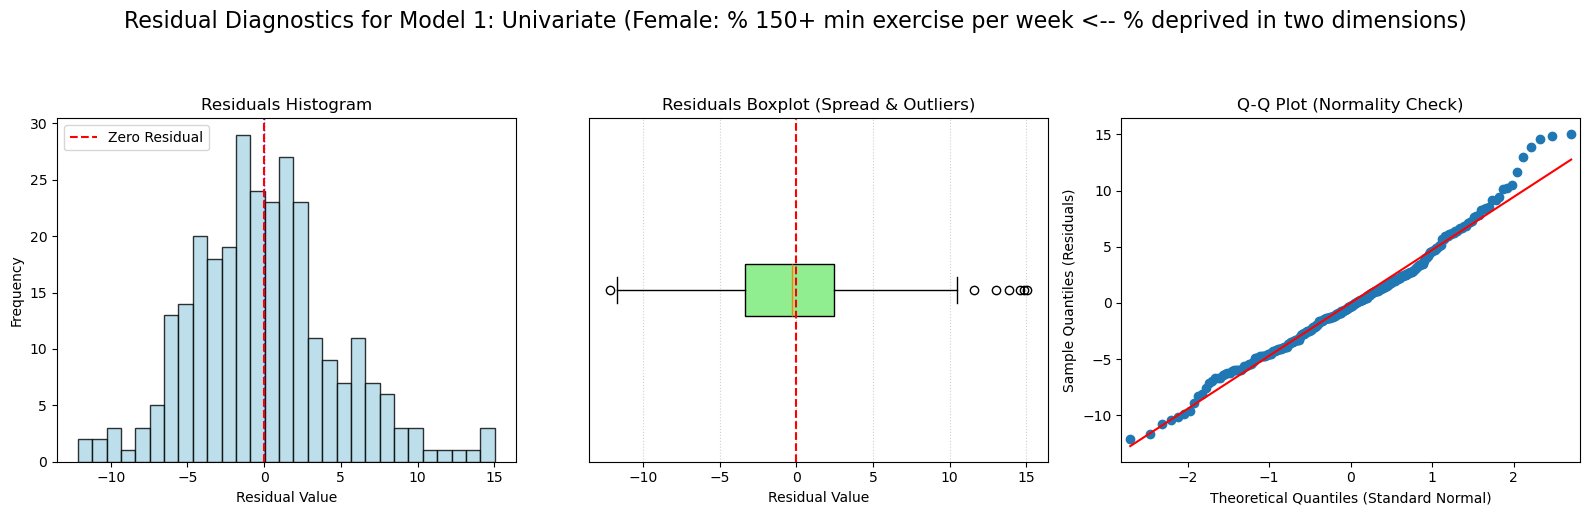

In [13]:
plot_single_model_diagnostics(df_uni['Residuals'], f"Model 1: Univariate ({TARGET_VAR} <-- {CHOSEN_PREDICTOR})")

## Analyse joint distributions of __model residuals__ against __feature values__

Identify variables whose value distributions with respect to the model residuals are prominently non-random. For a better model fit, you will need to include obe of these variables in the next (bivariate) version of the model. You should look not only for high positive or negative correlation but also at the distribution of the feature values. If the distribution is skewed, has gaps or sparsely populated intervals, or has outliers, the feature is not a good predictor.

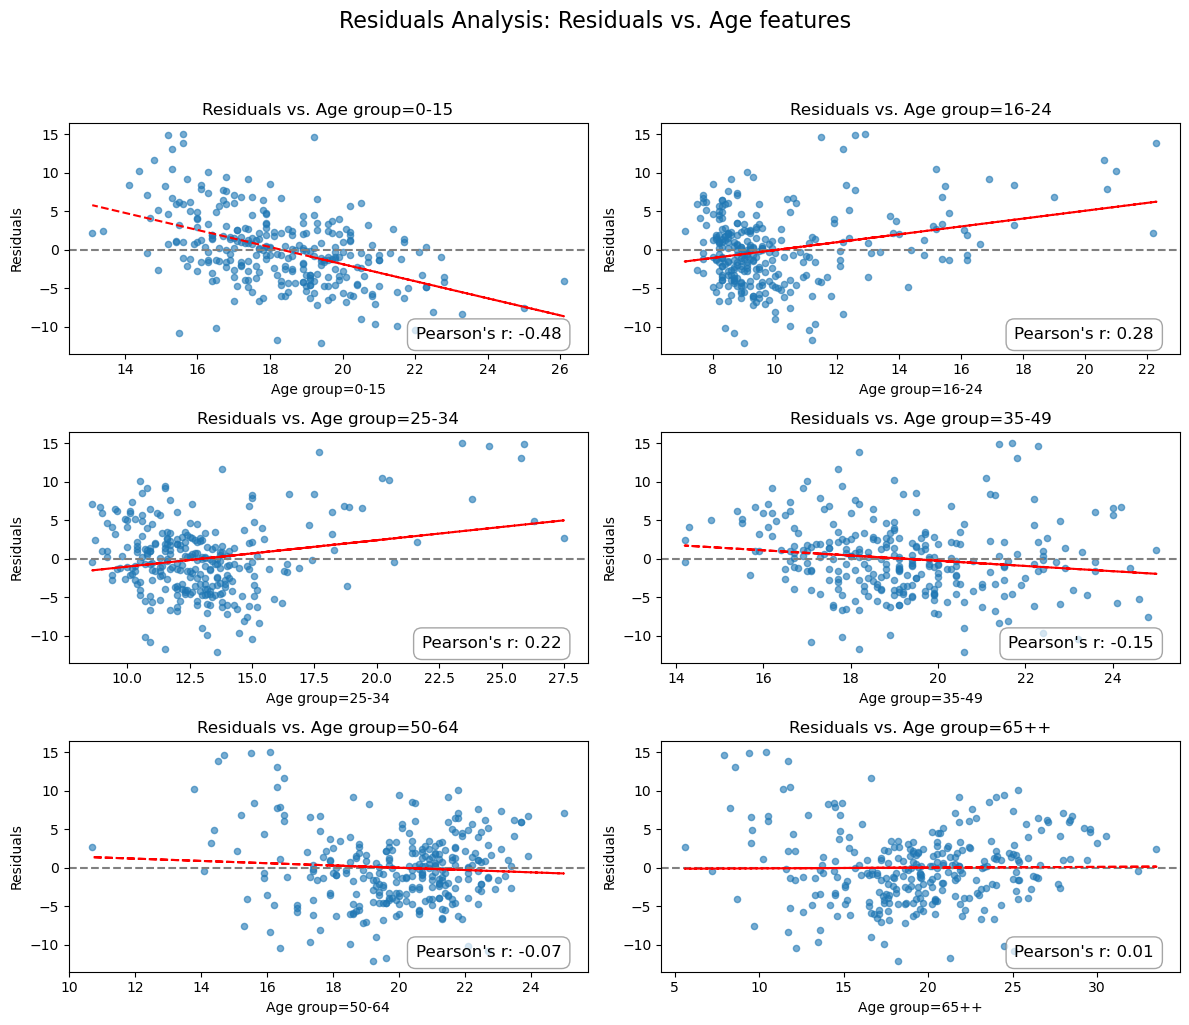

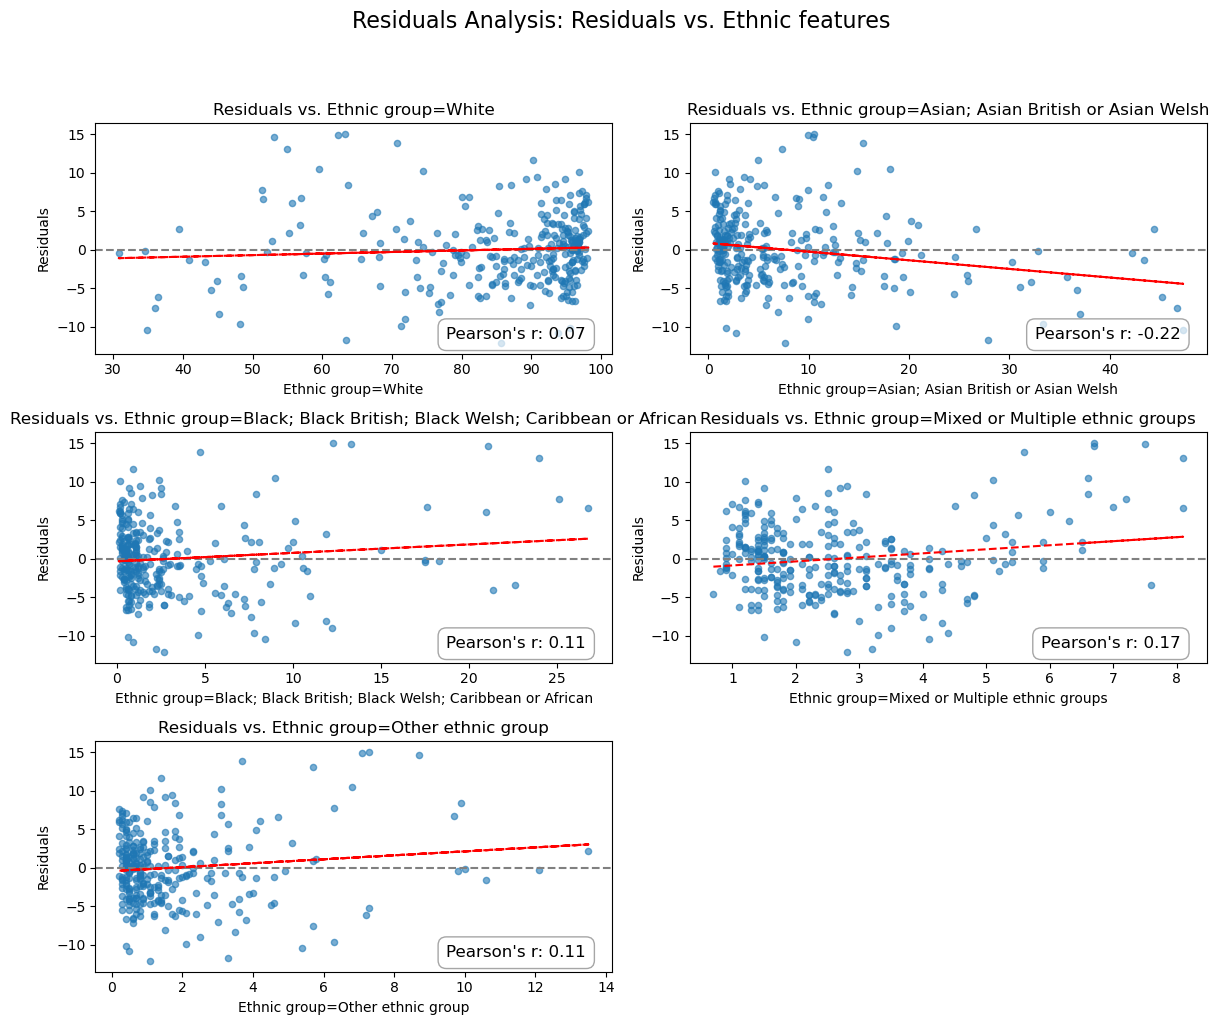

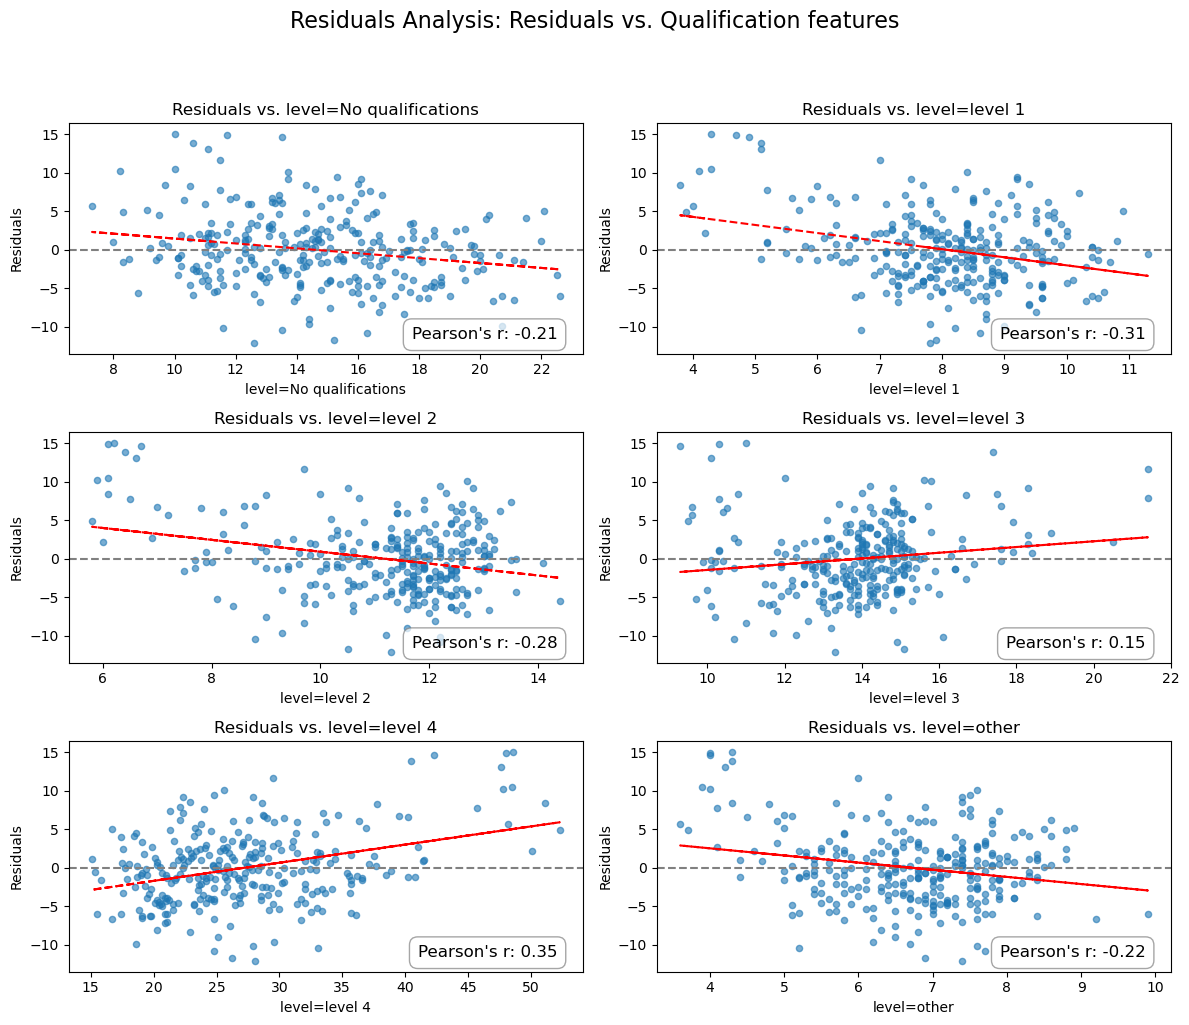

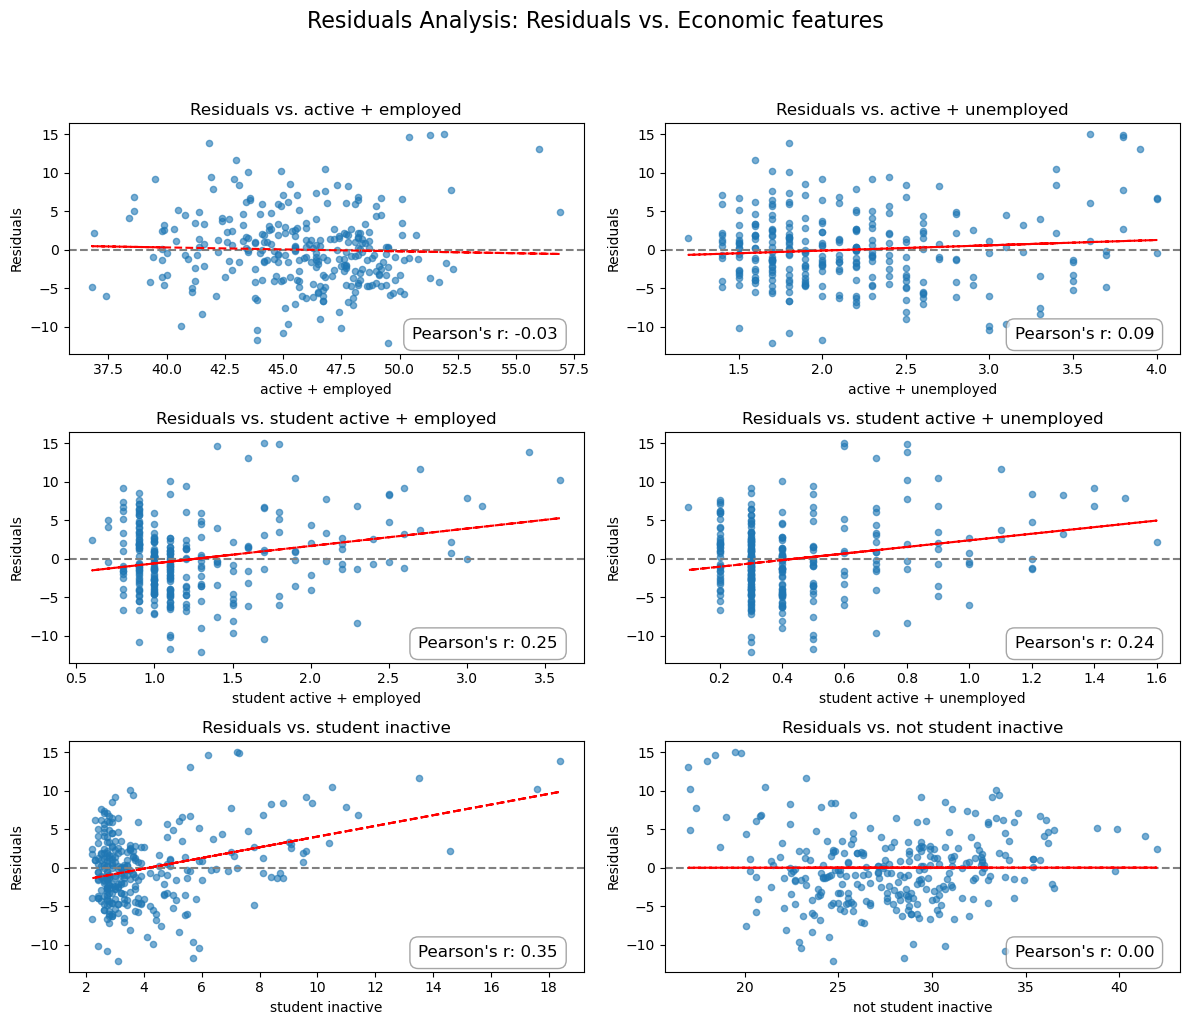

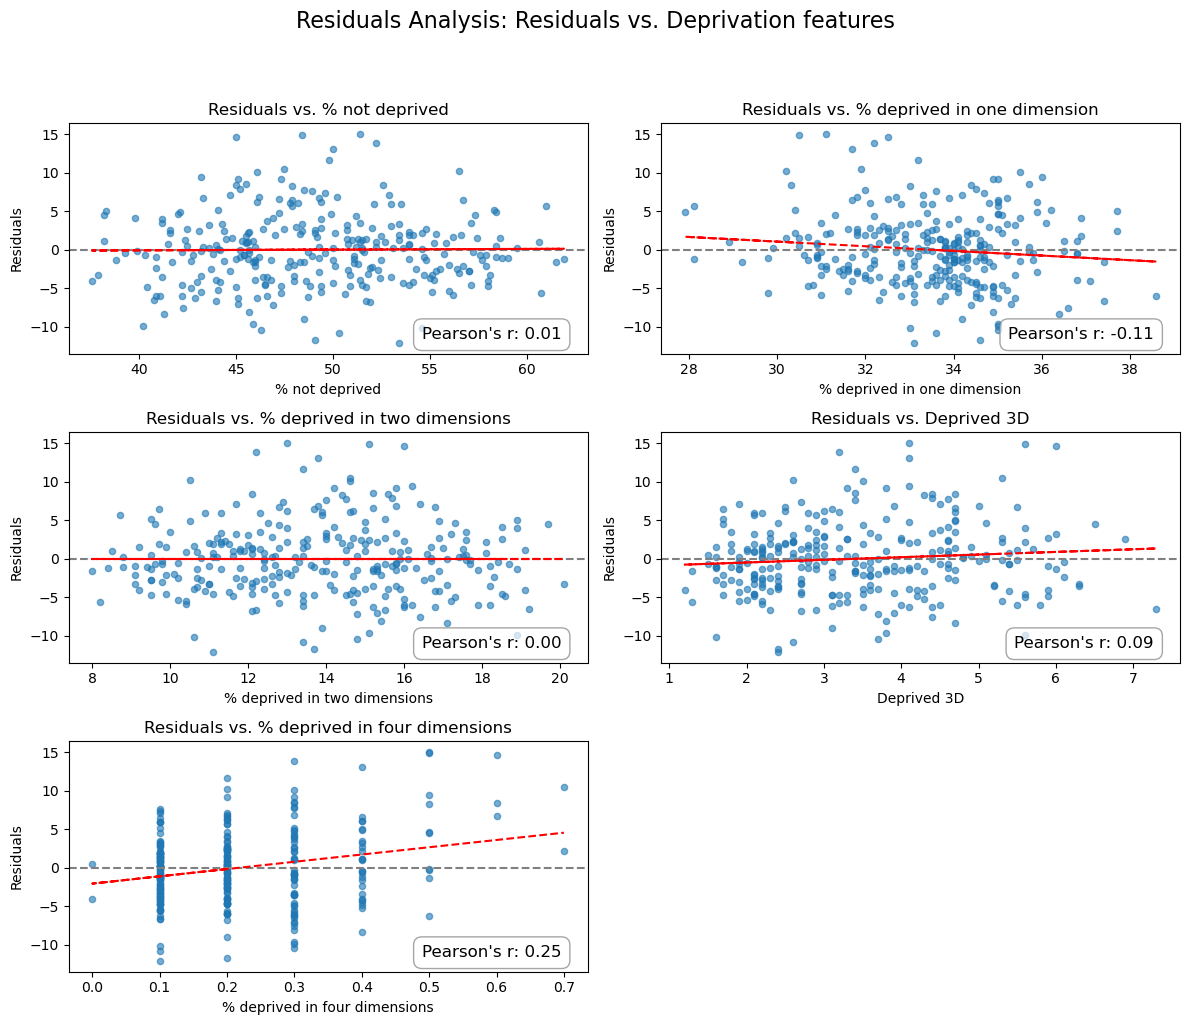

In [14]:
df_with_results = df.merge(
    df_uni[['id', TARGET_VAR, 'Residuals']], # Select only the key and result columns
    on='id',       # Key column to match rows
    how='left'     # Keep all rows from the original 'df', adding results where available
)

df_analysis = df_with_results[['Residuals']+age_features].dropna()
plot_residuals(df_analysis, 'Residuals', age_features, 'Age features')

df_analysis = df_with_results[['Residuals']+ethnic_features].dropna()
plot_residuals(df_analysis, 'Residuals', ethnic_features, 'Ethnic features')

df_analysis = df_with_results[['Residuals']+qualification_features].dropna()
plot_residuals(df_analysis, 'Residuals', qualification_features, 'Qualification features')

df_analysis = df_with_results[['Residuals']+economic_features].dropna()
plot_residuals(df_analysis, 'Residuals', economic_features, 'Economic features')

df_analysis = df_with_results[['Residuals']+deprivation_features].dropna()
plot_residuals(df_analysis, 'Residuals', deprivation_features, 'Deprivation features')


## __Refine the model__ by including an additional feature. 
Use the feature you have chosen based on the analysis of the residual distributions against the different features. 

After the model is built, look at the __F-statistic's $P$-value__ and the __Adjusted $R^2$__ and compare these with the corresponding metrics of the initial model to check whether and how much the model's explanatory power has improved.

In [15]:
# --- Bivariate Regression ---
PREDICTOR_2 = 'Age group=0-15: % by age'

df_bi, model_bi = run_regression(
    df, TARGET_VAR, [CHOSEN_PREDICTOR, PREDICTOR_2]
)
print_model_summary(model_bi, TARGET_VAR, [CHOSEN_PREDICTOR, PREDICTOR_2])


--- Regression Model Summary ---
                                     OLS Regression Results                                     
Dep. Variable:     Female: % 150+ min exercise per week   R-squared:                       0.594
Model:                                              OLS   Adj. R-squared:                  0.591
Method:                                   Least Squares   F-statistic:                     210.0
Date:                                  Thu, 16 Oct 2025   Prob (F-statistic):           6.42e-57
Time:                                          14:10:59   Log-Likelihood:                -822.42
No. Observations:                                   290   AIC:                             1651.
Df Residuals:                                       287   BIC:                             1662.
Df Model:                                             2                                         
Covariance Type:                              nonrobust                                       

## __Compare the error distributions__ of the two model versions
Recall the previous comments about interpreting visualisations of error distribution. Look if the new model has a better distribution of residuals than the previous version.

### __Note__: Not necessarily the model improves when you add one more predictor.
When you see that the model does not get significantly better, you should try to substitute the feature you have added by another feature. You may need to do this several times until you achieve substantial improvement __both in terms of accuracy and in terms of residual distributions__. Still, it is possible that you cannot improve the model anymore. In such a case, you take the previous version of the model as the final one. If its accuracy is insufficient (i.e., errors are too high), you may need to find additional data (not available in your current dataset) that could be used as good predictors for the target.

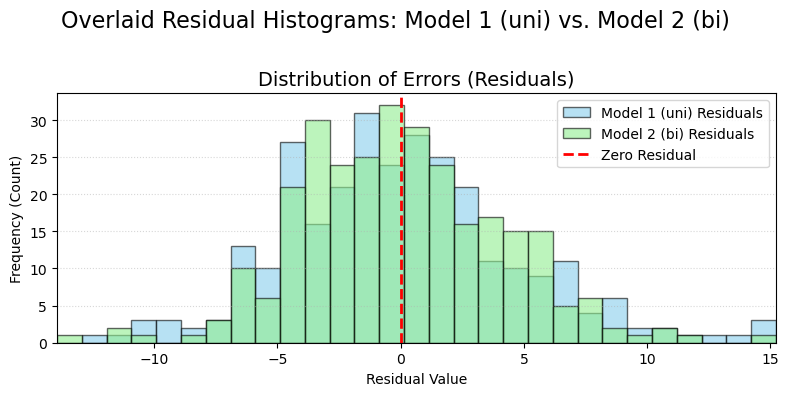

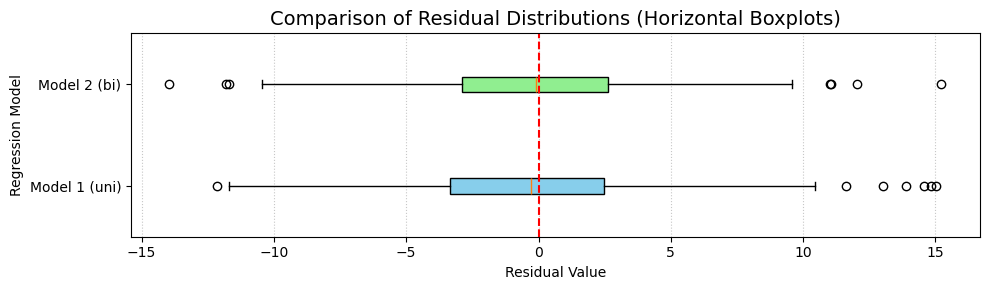


Mean Model Improvement (Model 1 (uni) Error - Model 2 (bi) Error): 0.4140


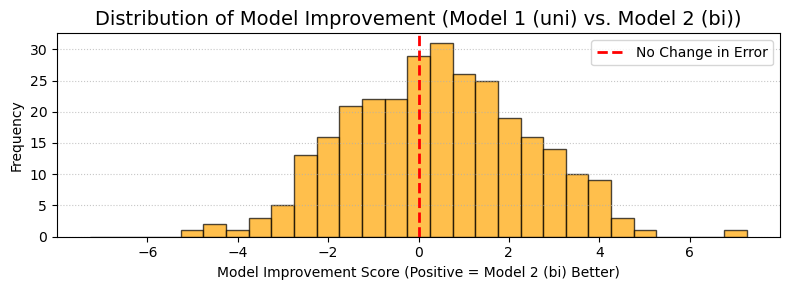

In [16]:
# --- Model Comparison Plots ---
df_resid_compare, model_1, model_2  = compare_models_hist_box(
    df, TARGET_VAR,
    [CHOSEN_PREDICTOR], [CHOSEN_PREDICTOR, PREDICTOR_2], labels = ['Model 1 (uni)', 'Model 2 (bi)']
)

## Use Q-Q plots to compare the models regarding the __normality__ of their error distributions

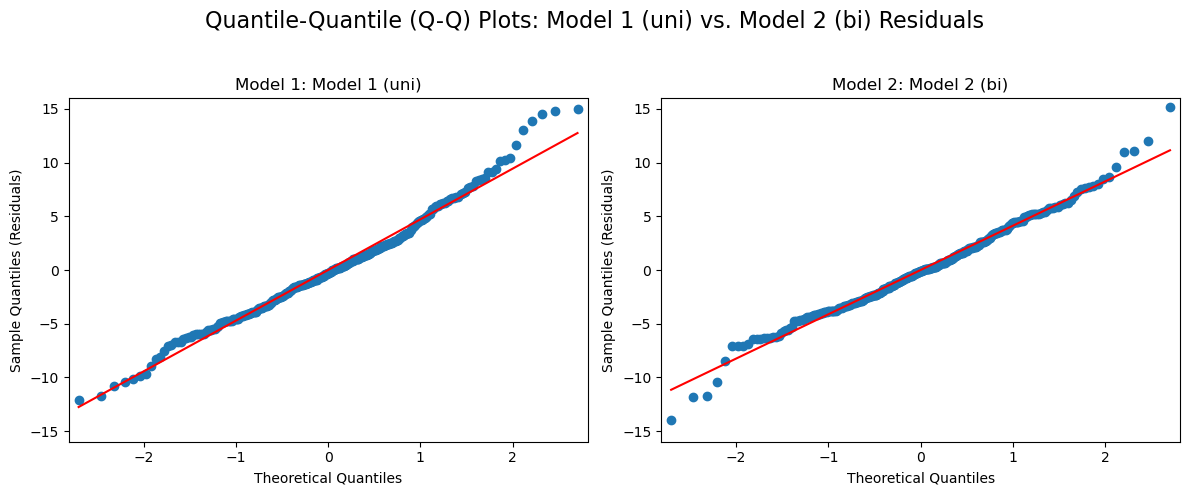

In [17]:
plot_qq_comparison(model_1, model_2, 'Model 1 (uni)', 'Model 2 (bi)')


## Use choropleth maps to examine the __geographical distributions__ of the residuals of the two models and see where the each of the models outperforms the other.

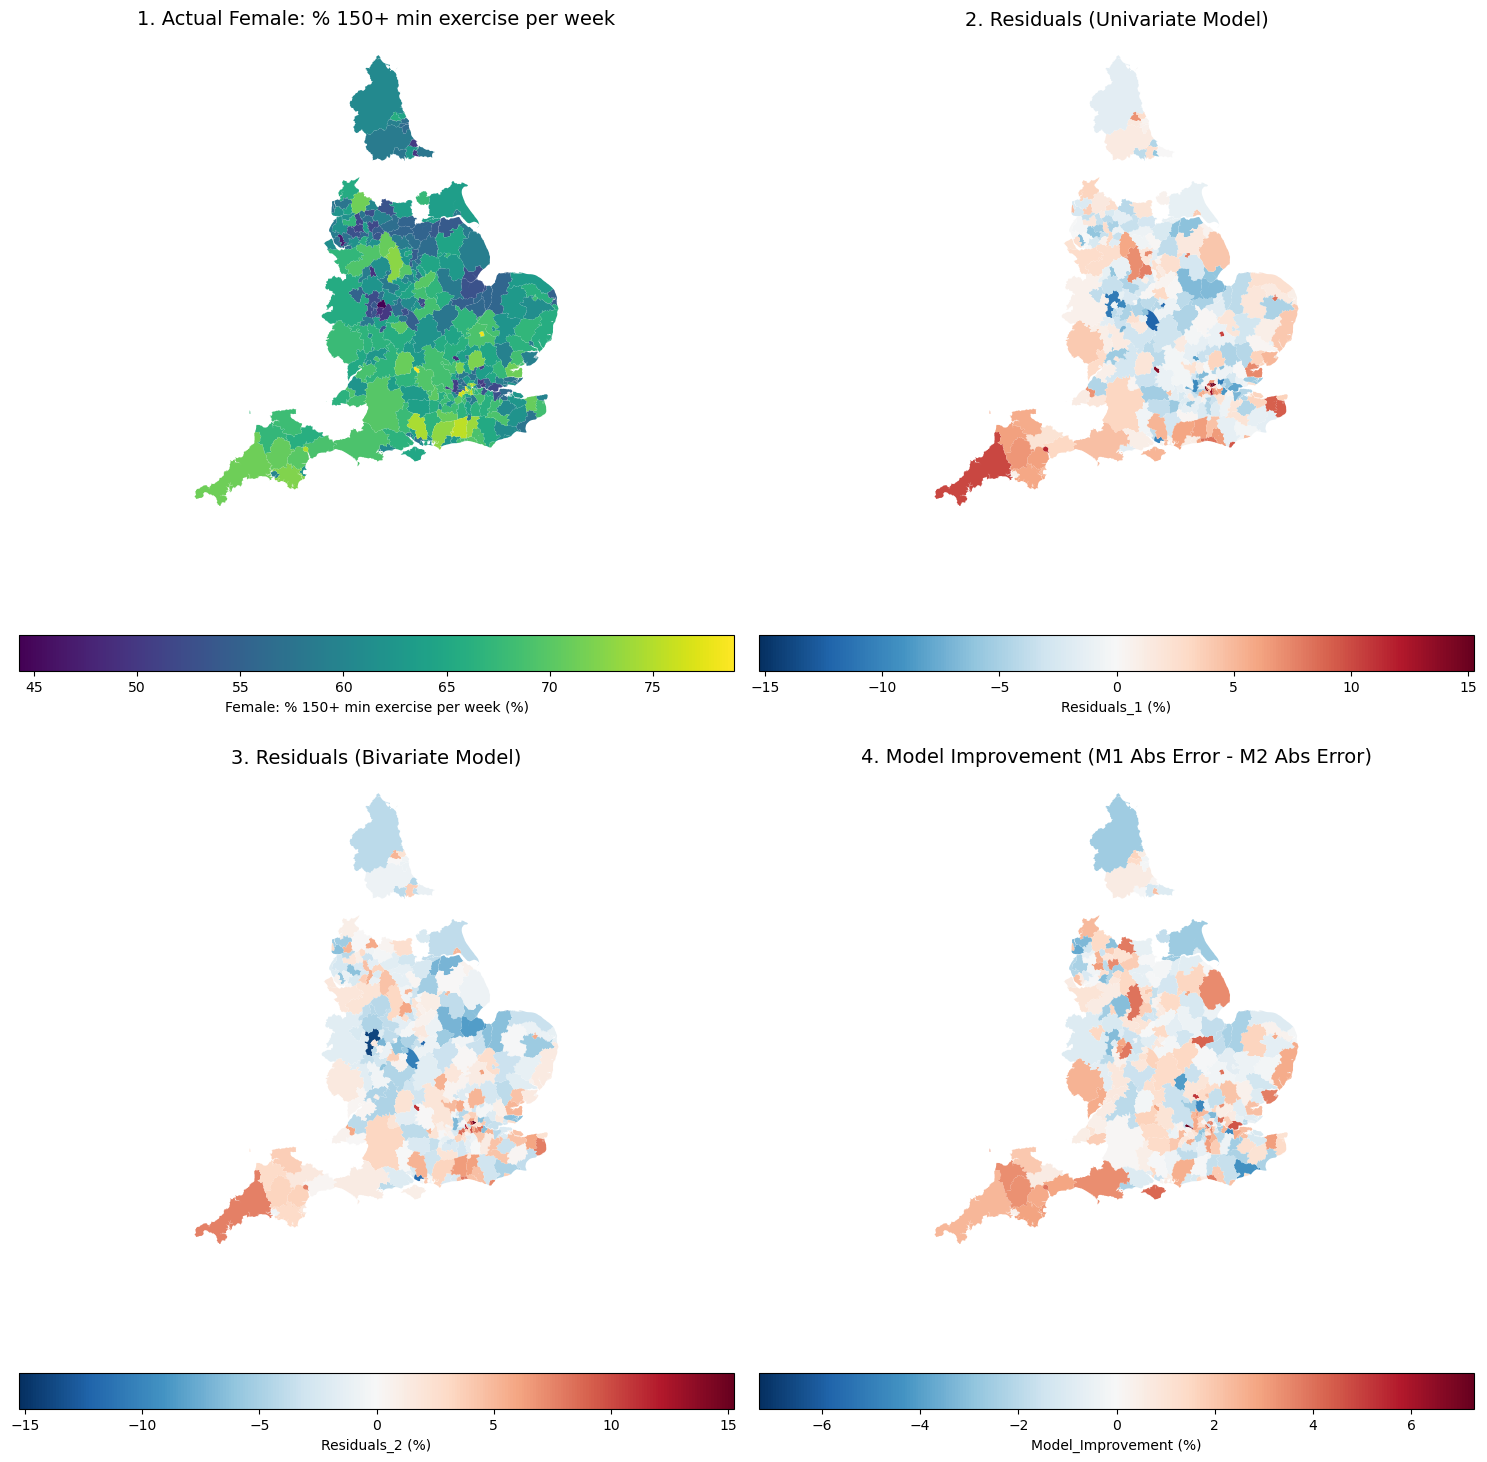

In [18]:
# --- Mapping ---
# Load boundaries and join
shapefile_path = 'LAD_DEC_2023_UK_BGC.shp'
try:
    gdf = gpd.read_file(shapefile_path)
except Exception as e:
    print(f"Error loading shapefile: {e}")
    print("Ensure all required files (.shp, .shx, .dbf, .cpg) are in the directory.")
    exit()
gdf = gdf.merge(df_resid_compare, left_on='LAD23CD', right_on='id', how='left')
gdf_plot = gdf.dropna(subset=[TARGET_VAR])

PLOT_VARS = [
    TARGET_VAR, 
    'Residuals_1', 
    'Residuals_2', 
    'Model_Improvement'
]
TITLES = [
    f"1. Actual {TARGET_VAR}", 
    '2. Residuals (Univariate Model)', 
    '3. Residuals (Bivariate Model)', 
    '4. Model Improvement (M1 Abs Error - M2 Abs Error)'
]
plot_maps(gdf_plot, PLOT_VARS, TITLES, TARGET_VAR)

## Analyse the joint distributions of __model residuals__ and __feature values__
Like for Model 1, identify variables whose value distributions with respect to the model residuals are prominently non-random. If you consider including obe of these variables in the next (trivariate) version of the model, you should look not only for high positive or negative correlation but also at the distribution of the feature values. If the distribution is skewed, has gaps or sparsely populated intervals, or has outliers, the feature is not a good predictor.

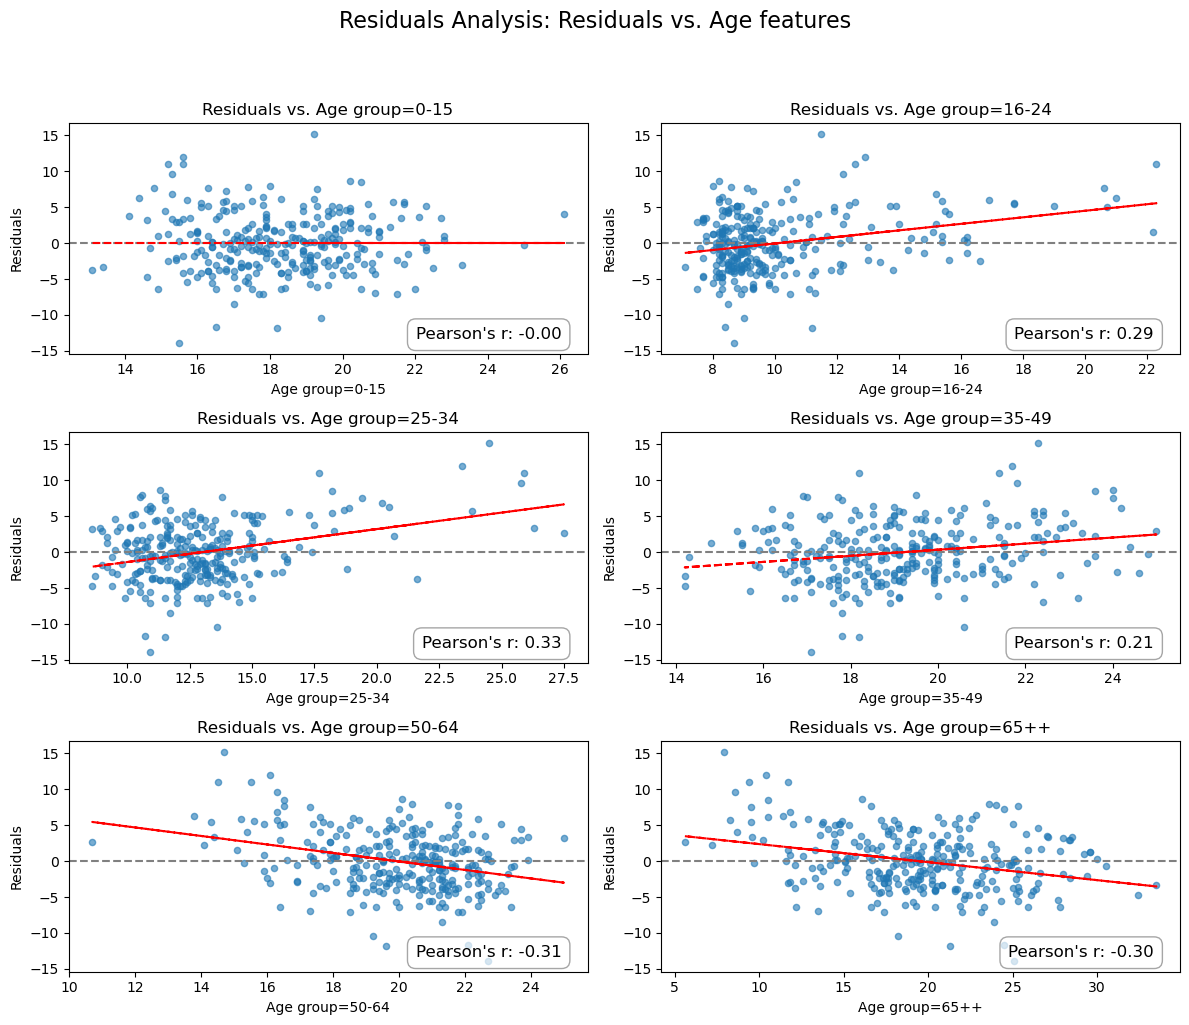

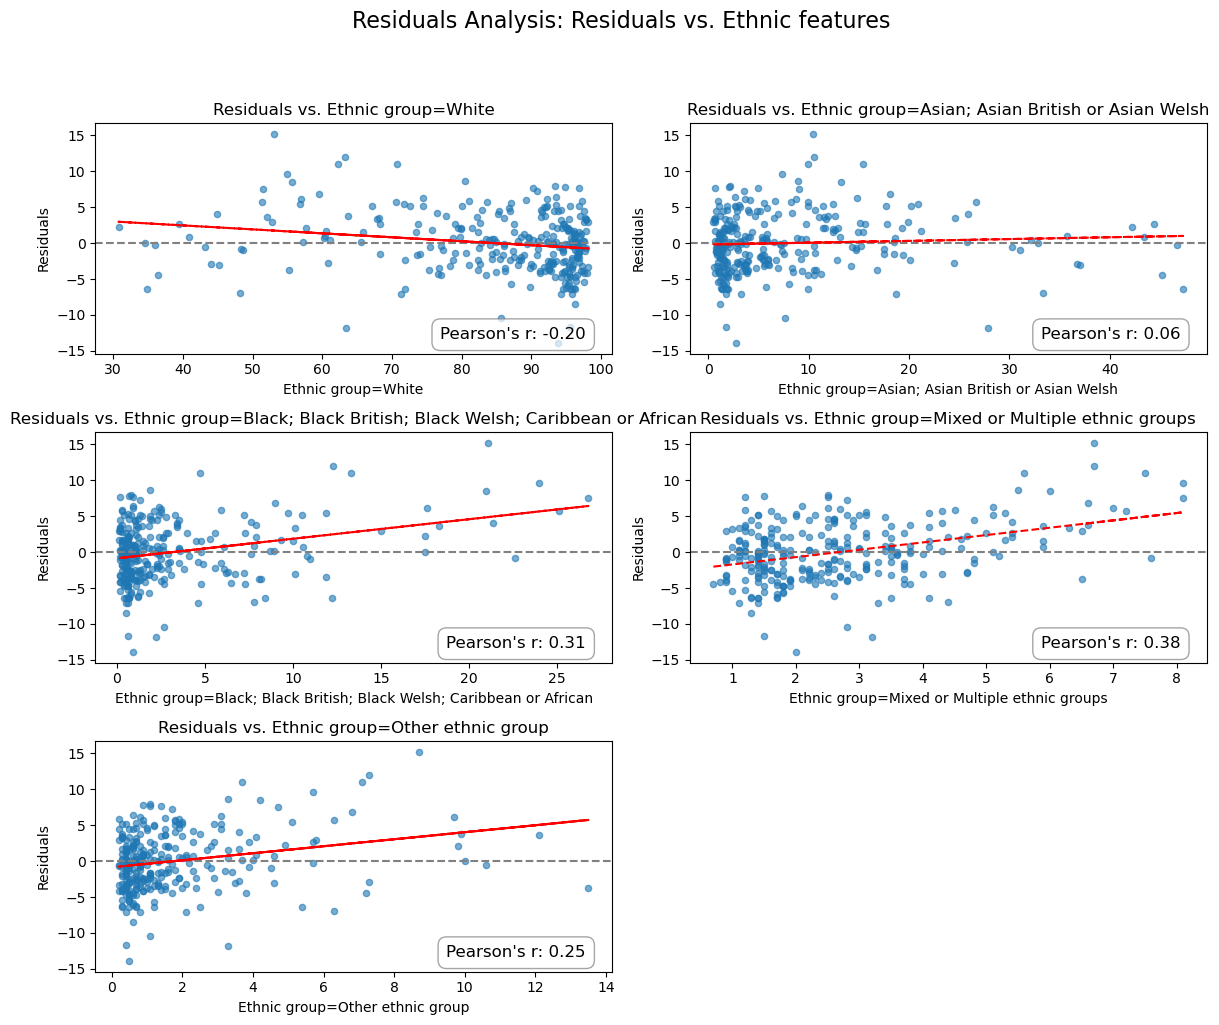

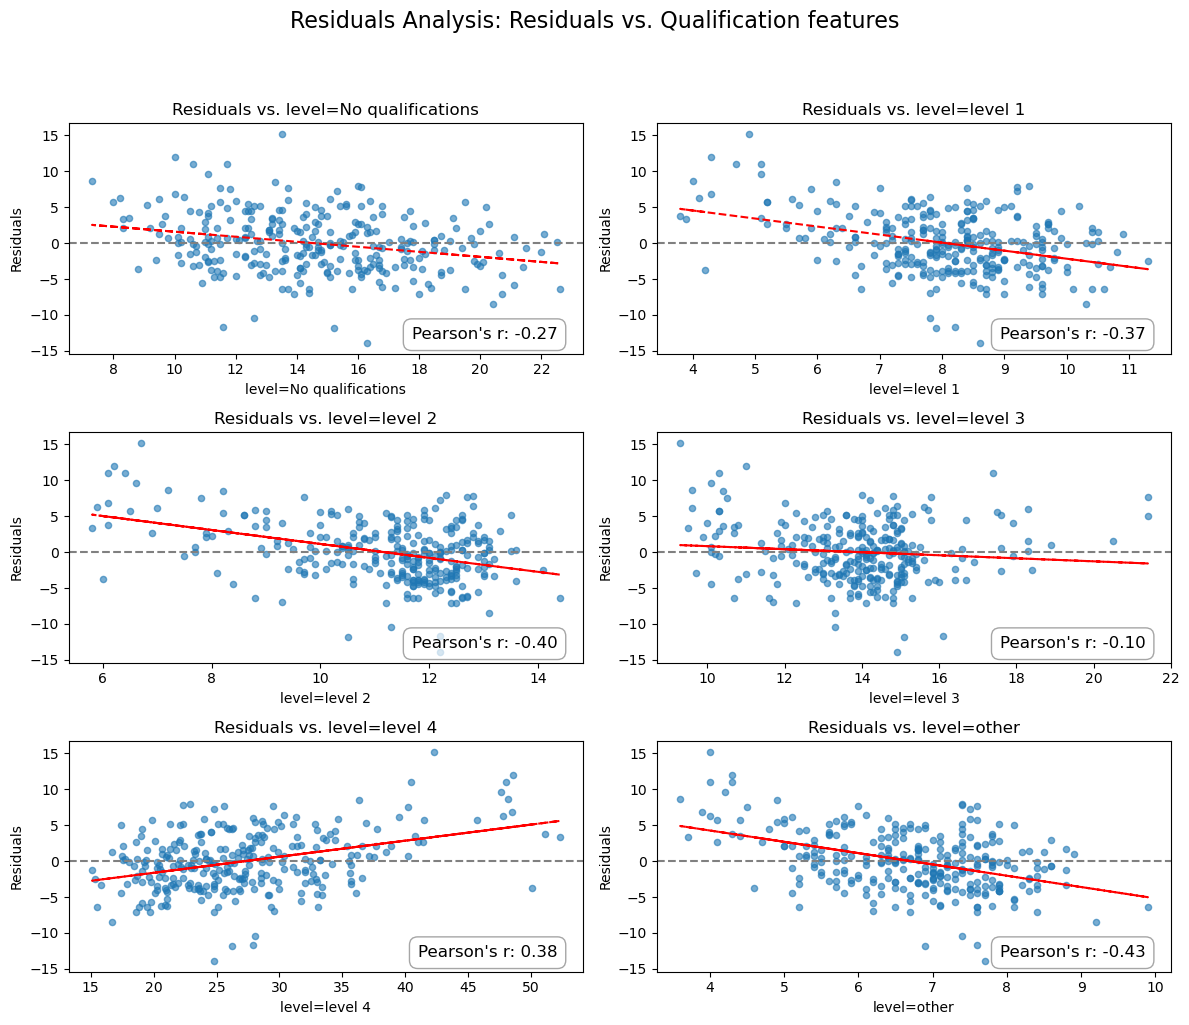

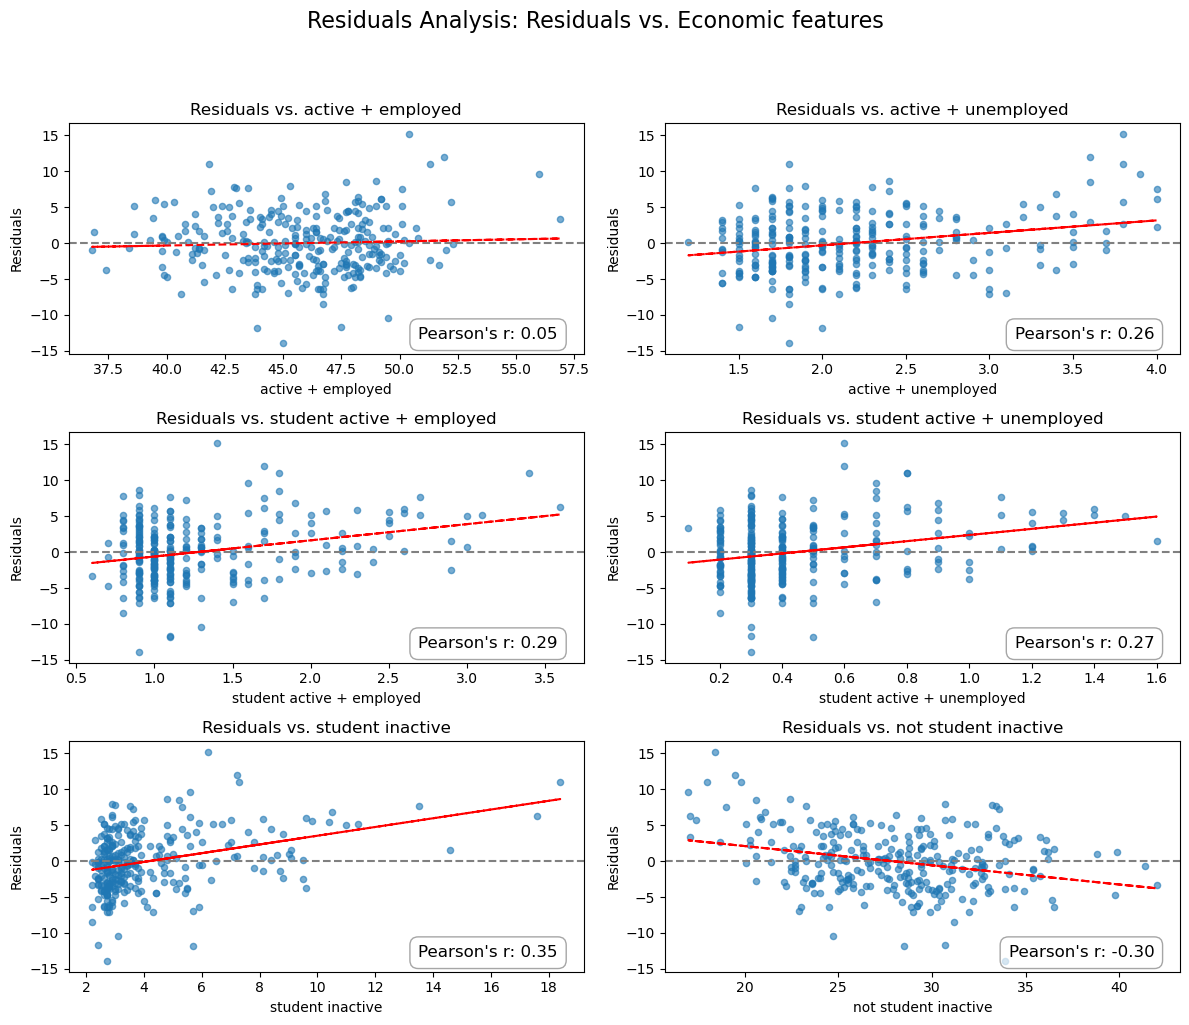

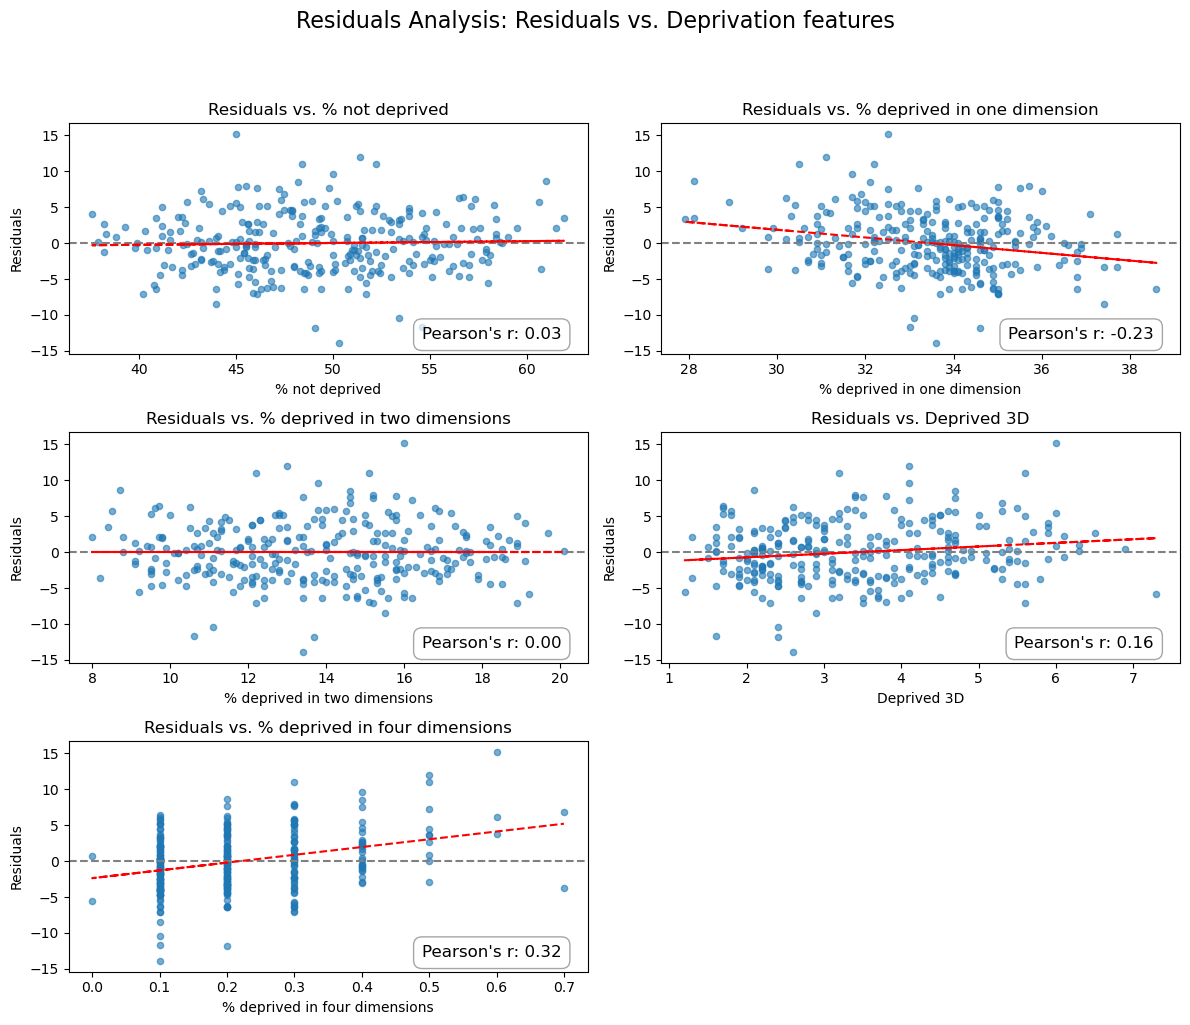

In [19]:
df_with_results = df.merge(
    df_bi[['id', TARGET_VAR, 'Residuals']], # Select only the key and result columns
    on='id',       # Key column to match rows
    how='left'     # Keep all rows from the original 'df', adding results where available
)

df_analysis = df_with_results[['Residuals']+age_features].dropna()
plot_residuals(df_analysis, 'Residuals', age_features, 'Age features')

df_analysis = df_with_results[['Residuals']+ethnic_features].dropna()
plot_residuals(df_analysis, 'Residuals', ethnic_features, 'Ethnic features')

df_analysis = df_with_results[['Residuals']+qualification_features].dropna()
plot_residuals(df_analysis, 'Residuals', qualification_features, 'Qualification features')

df_analysis = df_with_results[['Residuals']+economic_features].dropna()
plot_residuals(df_analysis, 'Residuals', economic_features, 'Economic features')

df_analysis = df_with_results[['Residuals']+deprivation_features].dropna()
plot_residuals(df_analysis, 'Residuals', deprivation_features, 'Deprivation features')

## Next step: __refine the model further__ by adding one more predictor
Look at the __F-statistic's $P$-value__ and the __Adjusted $R^2$__ to compare the model's explanatory power against other models.

In [20]:
# --- Trivariate Regression Example ---
PREDICTOR_3 = 'level=level 2: % by qualification level'

df_tri, model_tri = run_regression(
    df, TARGET_VAR, [CHOSEN_PREDICTOR, PREDICTOR_2, PREDICTOR_3]
)
print_model_summary(model_tri, TARGET_VAR, [CHOSEN_PREDICTOR, PREDICTOR_2, PREDICTOR_3])


--- Regression Model Summary ---
                                     OLS Regression Results                                     
Dep. Variable:     Female: % 150+ min exercise per week   R-squared:                       0.660
Model:                                              OLS   Adj. R-squared:                  0.656
Method:                                   Least Squares   F-statistic:                     184.9
Date:                                  Thu, 16 Oct 2025   Prob (F-statistic):           1.21e-66
Time:                                          14:16:37   Log-Likelihood:                -796.83
No. Observations:                                   290   AIC:                             1602.
Df Residuals:                                       286   BIC:                             1616.
Df Model:                                             3                                         
Covariance Type:                              nonrobust                                       

## __Compare__ the refined model with the __previous__ model version
This is done in the same way as comparing Model 2 to Model 1.

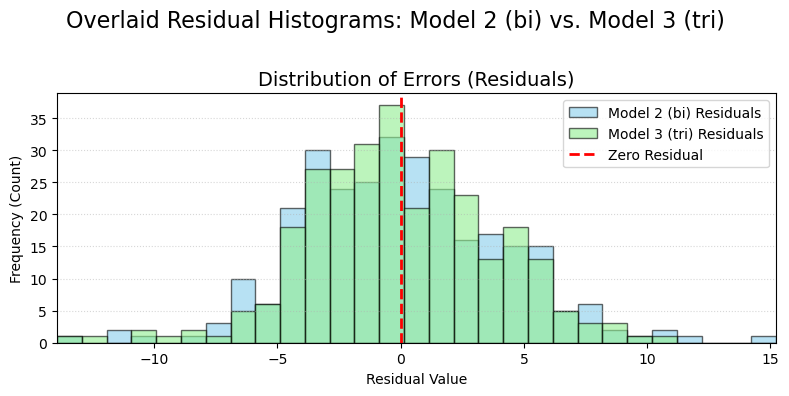

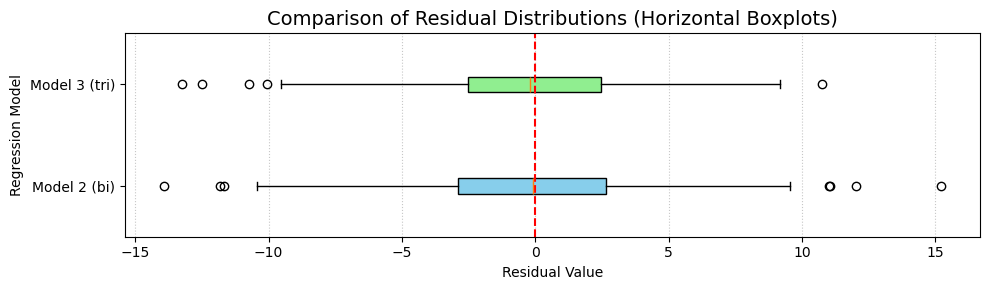


Mean Model Improvement (Model 2 (bi) Error - Model 3 (tri) Error): 0.2451


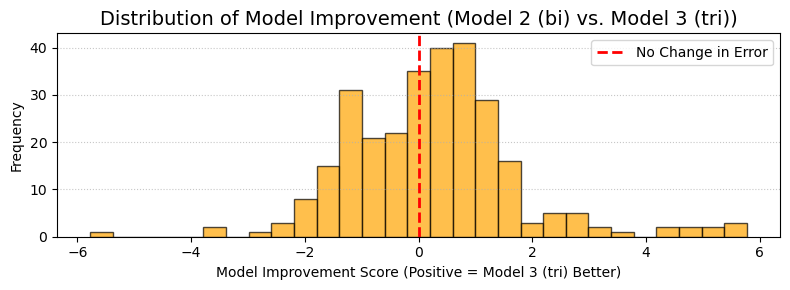

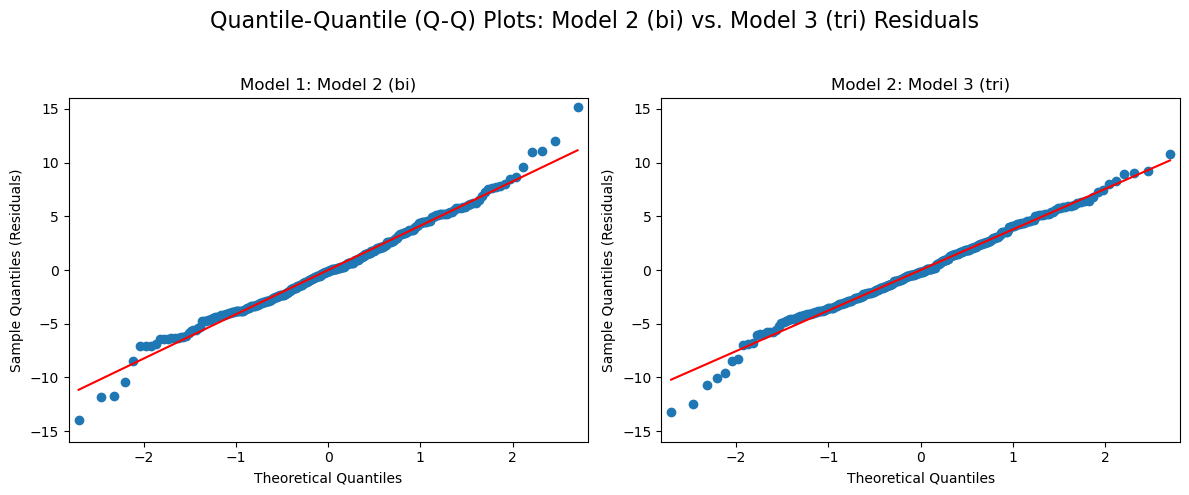

In [21]:
# --- Model Comparison Plots ---
df_resid_compare, model_2, model_3  = compare_models_hist_box(
    df, TARGET_VAR,
    [CHOSEN_PREDICTOR, PREDICTOR_2], [CHOSEN_PREDICTOR, PREDICTOR_2, PREDICTOR_3], labels = ['Model 2 (bi)', 'Model 3 (tri)']
)
plot_qq_comparison(model_2, model_3, 'Model 2 (bi)', 'Model 3 (tri)')


## __Compare__ the refined model with the __initial__ model version (Model 1)

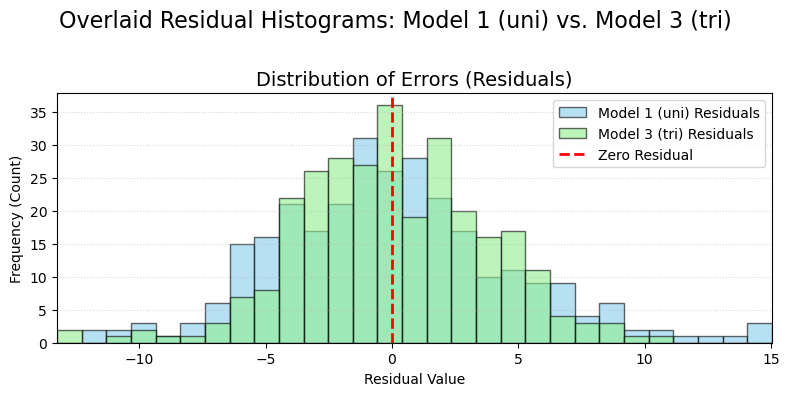

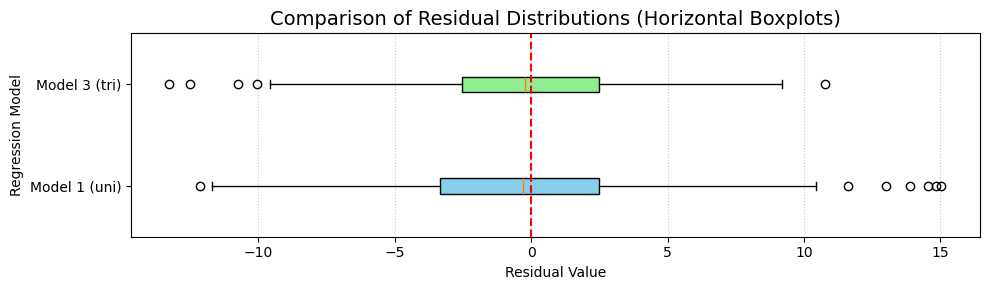


Mean Model Improvement (Model 1 (uni) Error - Model 3 (tri) Error): 0.6592


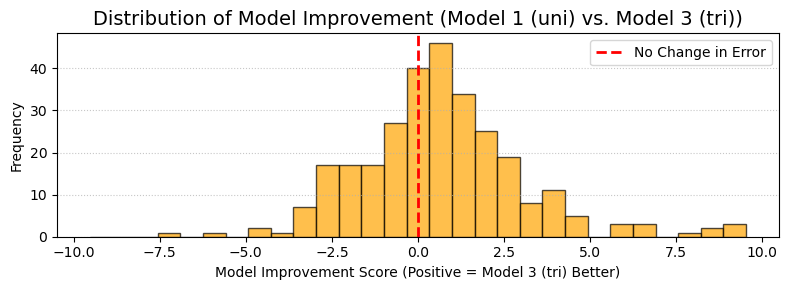

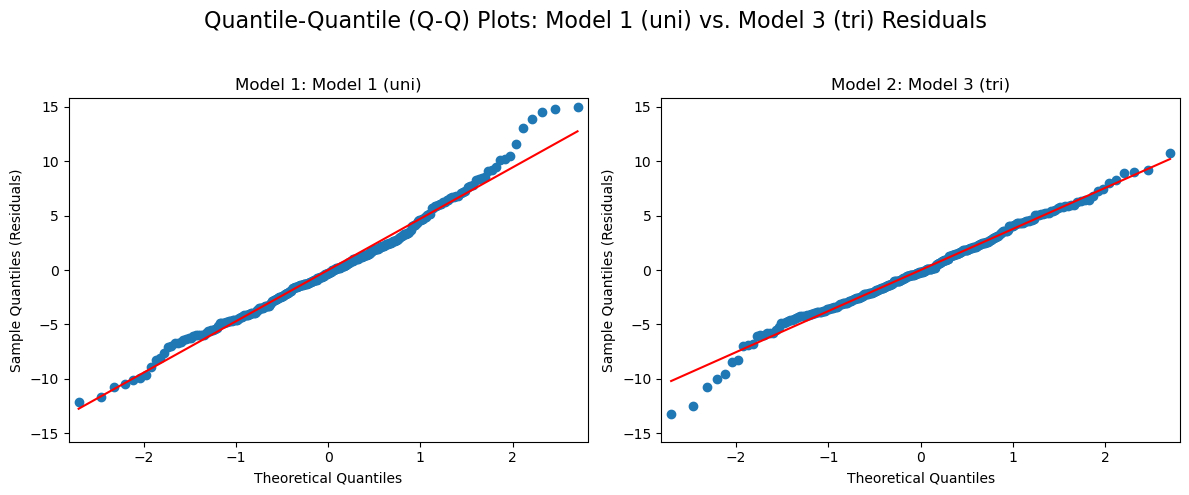

In [22]:
# --- Model Comparison Plots ---
df_resid_compare, model_1, model_3  = compare_models_hist_box(
    df, TARGET_VAR,
    [CHOSEN_PREDICTOR], [CHOSEN_PREDICTOR, PREDICTOR_2, PREDICTOR_3], labels = ['Model 1 (uni)', 'Model 3 (tri)']
)
plot_qq_comparison(model_1, model_3, 'Model 1 (uni)', 'Model 3 (tri)')


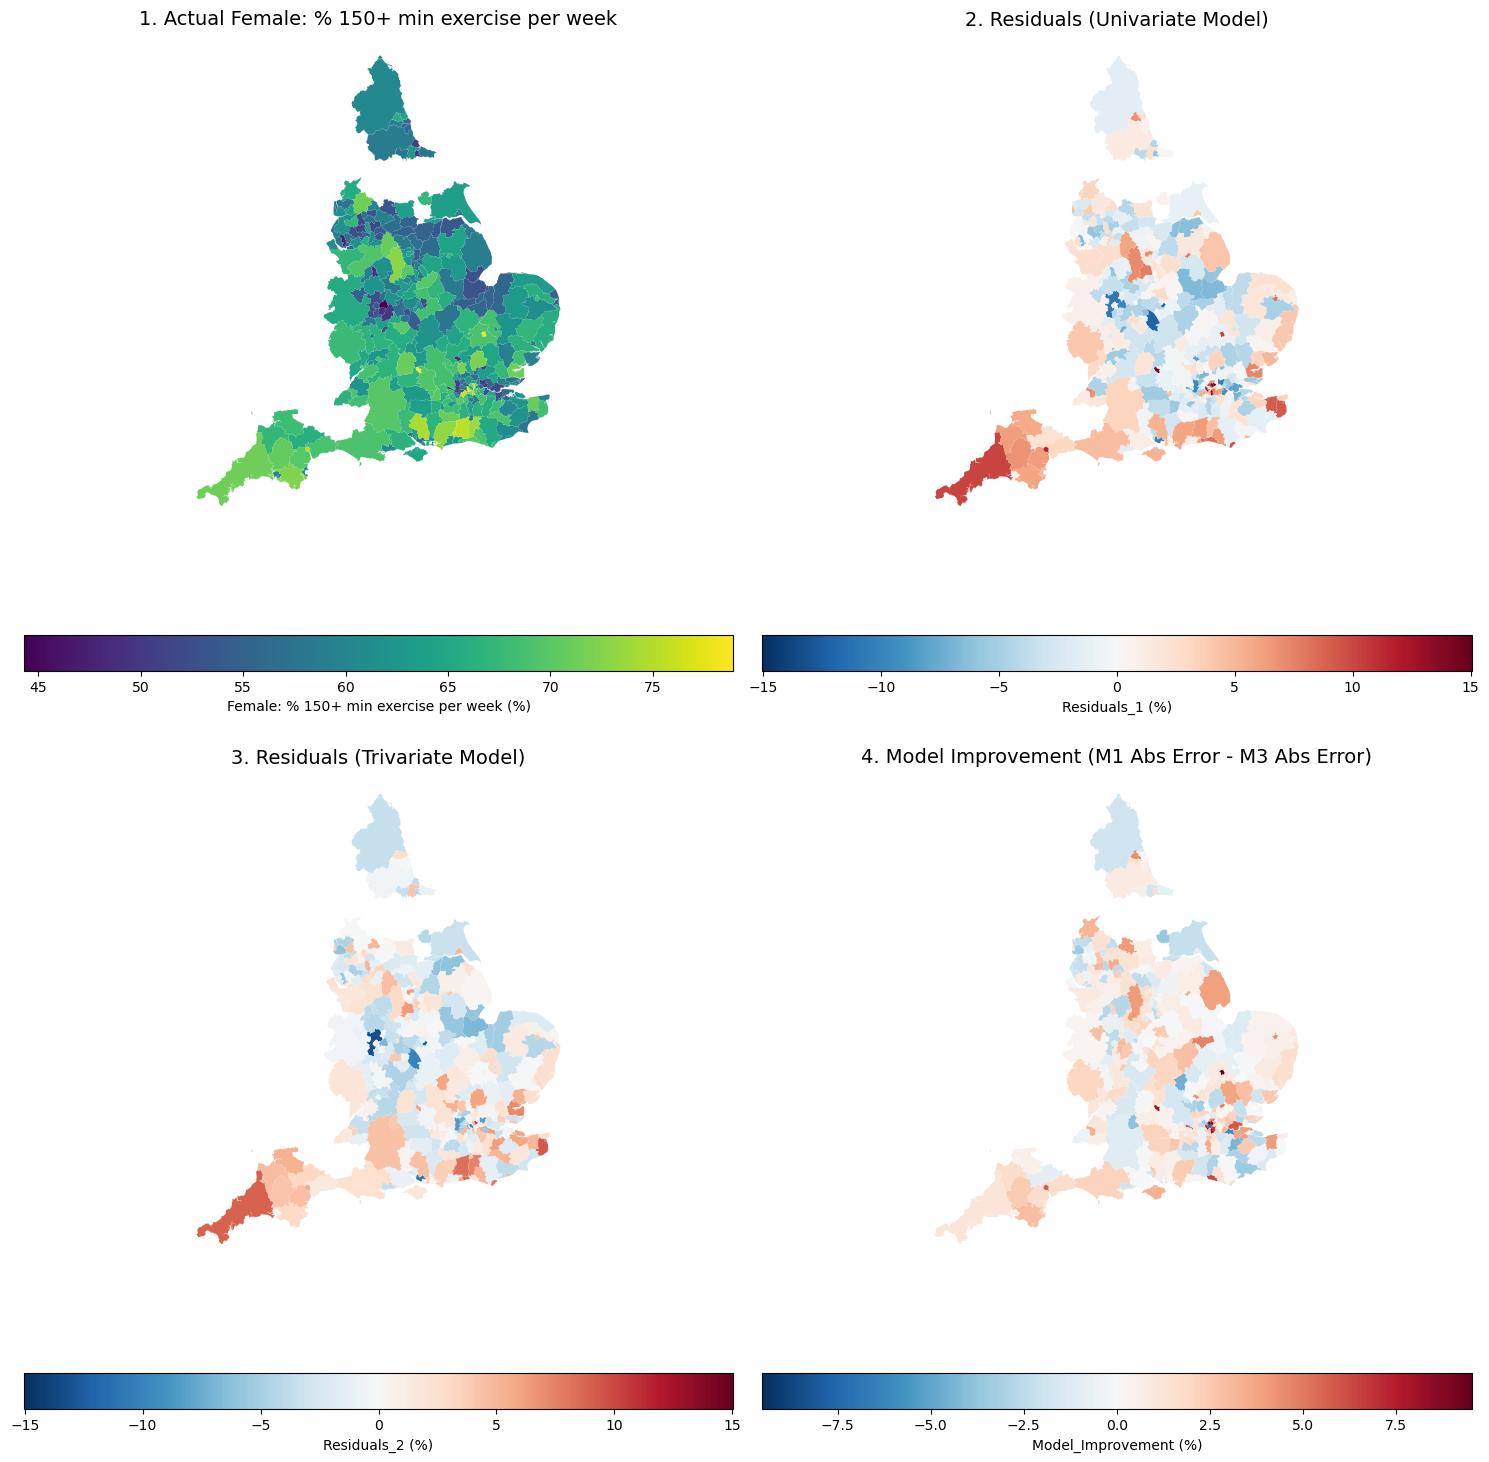

In [23]:
# --- Mapping ---
# Load boundaries and join
shapefile_path = 'LAD_DEC_2023_UK_BGC.shp'
try:
    gdf = gpd.read_file(shapefile_path)
except Exception as e:
    print(f"Error loading shapefile: {e}")
    print("Ensure all required files (.shp, .shx, .dbf, .cpg) are in the directory.")
    exit()
gdf = gdf.merge(df_resid_compare, left_on='LAD23CD', right_on='id', how='left')
gdf_plot = gdf.dropna(subset=[TARGET_VAR])

PLOT_VARS = [
    TARGET_VAR, 
    'Residuals_1', 
    'Residuals_2', 
    'Model_Improvement'
]
TITLES = [
    f"1. Actual {TARGET_VAR}", 
    '2. Residuals (Univariate Model)', 
    '3. Residuals (Trivariate Model)', 
    '4. Model Improvement (M1 Abs Error - M3 Abs Error)'
]
plot_maps(gdf_plot, PLOT_VARS, TITLES, TARGET_VAR)

# Conclusion: Beyond the Numbers – The Art of Model Diagnostics

We hope that you have successfully completed the iterative process of building and refining a multiple linear regression model. This means that, by progressing from a simple univariate model (Model 1) to a more complex trivariate model (model 3), you've not only improved your model's predictive power but, more importantly, enhanced its statistical validity.

The __core takeaway__ from this exercise is that model fitting is an __iterative process__, not a one-step calculation.
* __Initial Model__: Model 1 provided a baseline R2 but likely left significant patterns in the residuals (e.g., non-normality or systematic errors related to unincluded variables).
* __Refinement__: Your decisions to add subsequent predictors (Model 2 and Model 3) were not based on chance, but on the __analytical reasoning__ derived from observing residual patterns. For instance, if the residuals would show a pattern when plotted against the 'Deprivation' variable, that would be a strong signal that 'Deprivation' needed to be included.
* __Final Model__: Model 3 should exhibit the highest Adjusted $R^2$ and, critically, the cleanest diagnostics (residuals closest to normal).

## The Power of Visualizations
Visual diagnostics were the foundation of your success. __Residual histograms__ tell us	how accurate and symmetrical are the errors. __Q-Q plots__ show whether	the errors are truly random and normally distributed. __Geographic maps__ allow us to detect geographical patterns in error distributions, such as large regions of over- or under-estimation. Observing such patterns suggests that the model can be improved by geography-based _partitioning__ (which is tricky to do in Python and therefore has not been included in this exercise). __Scatterplots__ of the model residuals against the feature values have been used to identify features whose variation was not well captured by the model, so that these features could be added to the model for its refinement.

## Key points to remember:
1. __Normality is essential__: A good $R^2$ is useless if the errors are not normally distributed (as assessed by the Q-Q Plot).
2. __Residuals tell the story__: A model's errors are more informative than its predictions. If residual plots show patterns (curves, funnels, or clusters), it means you've missed a key variable or a non-linear relationship.
3. __Beyond purely numeric variables__: If your data include non-numeric dimensions (e.g., _spatial_, _temporal_, _categorical_), you need to examine the distributions of the residuals against these dimensions. Presence of non-random patterns in these distributions indicates a need to __partition__ the model in order to capture the variation over the non-numeric dimensions. The data in our example have a spatial dimension, therefore geographic maps were used to visualise the spatial distributions of the model errors.
 + We did not include partitioning in this notebook. However, in our example, you may notice a __pattern in the geographic distribution__ of the residuals: higher errors (both positive and negative) tend to occur in the southwestern part of the territory. It may thus be reasonable to __partition the data based on the geographical locations__ and create separate sub-models for the northeastern and southwestern parts. This task is left to you as a home exercise.

## The final insight: knowledge and reasoning outweigh calculation
It's crucial to end by underscoring the role of human expertise and analytical reasoning. The computer can calculate $R^2$ and plot residuals, but it cannot perform the most critical step: interpreting why a pattern exists and which variable to add next. The most powerful models are not just products of good algorithms. They are products of sound analytical reasoning that guides the analyst through the iterative diagnostic process. Your brain is the most important tool in data analysis and model building.